#Load the Data

In [ ]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts a PIL Image or numpy.ndarray to tensor.
    transforms.Normalize((0.5,), (0.5,))  # Normalizes a tensor image with mean and standard deviation.
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=1024, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 110827187.83it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 34017324.86it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 53633180.79it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11285858.27it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
len(trainset)

60000

In [ ]:
len(trainloader)

59

In [ ]:
60000/1024

58.59375

In [ ]:
for i in range(5):
  print(trainset[i][1])

5
0
4
1
9


#Visualize the Data

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array((0.5,))
        std = np.array((0.5,))
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image.squeeze(), cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis('off')

    return ax

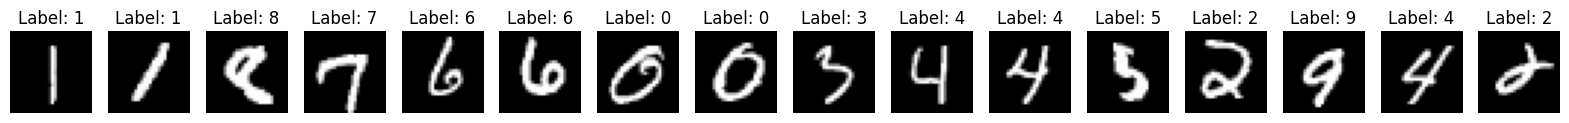

In [ ]:
# Visualize some images
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(figsize=(20, 4), ncols=16)
for ii in range(16):
    ax = axes[ii]
    imshow(images[ii], ax=ax, title=f"Label: {labels[ii]}")

#Analyze the Dataset

In [ ]:
# Print out some details about the dataset
print(f"Number of training images: {len(trainset)}")
print(f"Number of test images: {len(testset)}")
print(f"Image shape: {trainset[0][0].shape}")

# Analyze class distribution in the training dataset
from collections import Counter
train_labels = [label for _, label in trainset]
label_count = Counter(train_labels)
print("Training set label distribution:", label_count)


Number of training images: 60000
Number of test images: 10000
Image shape: torch.Size([1, 28, 28])
Training set label distribution: Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


#Define the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 input channel, 32 output channels, 3x3 kernel, stride 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Dropout layer to reduce overfitting
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)  # 9216 = number of pixels coming from the output of the second conv layer
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

    def forward(self, x):
        # Convolutional layers with ReLU activations
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        # Fully connected layers with dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output


#Set up Hyperparameters and Early Stopping

In [ ]:
# Hyperparameters
learning_rate = 0.001 #or 0.0001
batch_size = 1024
n_epochs = 50
patience = 5  # Number of epochs to wait after last time validation loss improved.

# Initialize the network and optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping details
val_loss_min = np.Inf
patience_counter = 0

In [ ]:
torch.cuda.is_available()

True

#Train-Validation-Test Split

In [ ]:
from torch.utils.data.dataset import random_split

# Define the size of the validation set
num_train = len(trainset)
num_valid = int(0.2 * num_train)  # Let's say we want 20% of the data for validation
num_train -= num_valid

# Split the dataset into training and validation sets
train_data, valid_data = random_split(trainset, [num_train, num_valid])


#Data Loaders

In [ ]:
# Create data loaders for the split datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

#Training Loop

In [ ]:
from tqdm import tqdm

# Training loop with early stopping
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0

    # Training the model
    model.train()
    for idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    # Validating the model
    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = 100. * correct / total

    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2f}%'.format(
        epoch, train_loss, valid_loss, accuracy))

    # Check if we should stop training early
    if valid_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        val_loss_min = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'EarlyStopping counter: {patience_counter} out of {patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break


100%|██████████| 188/188 [00:15<00:00, 12.02it/s]


Epoch: 1 	Training Loss: 0.261996 	Validation Loss: 0.063260 	Accuracy: 98.12%
Validation loss decreased (inf --> 0.063260).  Saving model ...


100%|██████████| 188/188 [00:12<00:00, 15.09it/s]


Epoch: 2 	Training Loss: 0.098917 	Validation Loss: 0.052945 	Accuracy: 98.39%
Validation loss decreased (0.063260 --> 0.052945).  Saving model ...


100%|██████████| 188/188 [00:12<00:00, 15.28it/s]


Epoch: 3 	Training Loss: 0.073005 	Validation Loss: 0.042085 	Accuracy: 98.75%
Validation loss decreased (0.052945 --> 0.042085).  Saving model ...


100%|██████████| 188/188 [00:11<00:00, 15.70it/s]


Epoch: 4 	Training Loss: 0.062872 	Validation Loss: 0.042142 	Accuracy: 98.83%
EarlyStopping counter: 1 out of 5


100%|██████████| 188/188 [00:11<00:00, 16.24it/s]


Epoch: 5 	Training Loss: 0.050745 	Validation Loss: 0.043085 	Accuracy: 98.84%
EarlyStopping counter: 2 out of 5


100%|██████████| 188/188 [00:13<00:00, 14.36it/s]


Epoch: 6 	Training Loss: 0.043837 	Validation Loss: 0.042646 	Accuracy: 98.83%
EarlyStopping counter: 3 out of 5


100%|██████████| 188/188 [00:11<00:00, 15.81it/s]


Epoch: 7 	Training Loss: 0.038301 	Validation Loss: 0.041539 	Accuracy: 98.96%
Validation loss decreased (0.042085 --> 0.041539).  Saving model ...


100%|██████████| 188/188 [00:11<00:00, 16.47it/s]


Epoch: 8 	Training Loss: 0.035839 	Validation Loss: 0.039988 	Accuracy: 99.00%
Validation loss decreased (0.041539 --> 0.039988).  Saving model ...


100%|██████████| 188/188 [00:11<00:00, 16.63it/s]


Epoch: 9 	Training Loss: 0.031567 	Validation Loss: 0.041569 	Accuracy: 99.01%
EarlyStopping counter: 1 out of 5


 84%|████████▍ | 630/750 [01:47<00:20,  5.89it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

# Training loop with early stopping
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0

    # Training the model
    model.train()
    for idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    # Validating the model
    model.eval()
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = 100. * correct / total

    # Print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.2f}%'.format(
        epoch, train_loss, valid_loss, accuracy))

    # Check if we should stop training early
    if valid_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        val_loss_min = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'EarlyStopping counter: {patience_counter} out of {patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break


100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


Epoch: 1 	Training Loss: 0.680260 	Validation Loss: 0.186500 	Accuracy: 94.73%
Validation loss decreased (inf --> 0.186500).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Epoch: 2 	Training Loss: 0.197351 	Validation Loss: 0.093821 	Accuracy: 97.40%
Validation loss decreased (0.186500 --> 0.093821).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.51it/s]


Epoch: 3 	Training Loss: 0.121933 	Validation Loss: 0.063801 	Accuracy: 98.08%
Validation loss decreased (0.093821 --> 0.063801).  Saving model ...


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


Epoch: 4 	Training Loss: 0.088928 	Validation Loss: 0.053616 	Accuracy: 98.33%
Validation loss decreased (0.063801 --> 0.053616).  Saving model ...


100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch: 5 	Training Loss: 0.075082 	Validation Loss: 0.046708 	Accuracy: 98.69%
Validation loss decreased (0.053616 --> 0.046708).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.28it/s]


Epoch: 6 	Training Loss: 0.066392 	Validation Loss: 0.045279 	Accuracy: 98.62%
Validation loss decreased (0.046708 --> 0.045279).  Saving model ...


100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


Epoch: 7 	Training Loss: 0.058016 	Validation Loss: 0.039832 	Accuracy: 98.83%
Validation loss decreased (0.045279 --> 0.039832).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.43it/s]


Epoch: 8 	Training Loss: 0.052722 	Validation Loss: 0.039657 	Accuracy: 98.84%
Validation loss decreased (0.039832 --> 0.039657).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch: 9 	Training Loss: 0.046594 	Validation Loss: 0.037135 	Accuracy: 98.89%
Validation loss decreased (0.039657 --> 0.037135).  Saving model ...


100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


Epoch: 10 	Training Loss: 0.042516 	Validation Loss: 0.034788 	Accuracy: 99.01%
Validation loss decreased (0.037135 --> 0.034788).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.31it/s]


Epoch: 11 	Training Loss: 0.039691 	Validation Loss: 0.035502 	Accuracy: 99.03%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Epoch: 12 	Training Loss: 0.037326 	Validation Loss: 0.034327 	Accuracy: 98.98%
Validation loss decreased (0.034788 --> 0.034327).  Saving model ...


100%|██████████| 12/12 [00:03<00:00,  3.48it/s]


Epoch: 13 	Training Loss: 0.036156 	Validation Loss: 0.035767 	Accuracy: 98.96%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.50it/s]


Epoch: 14 	Training Loss: 0.032189 	Validation Loss: 0.033878 	Accuracy: 99.01%
Validation loss decreased (0.034327 --> 0.033878).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch: 15 	Training Loss: 0.031001 	Validation Loss: 0.035578 	Accuracy: 99.03%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:03<00:00,  3.68it/s]


Epoch: 16 	Training Loss: 0.028231 	Validation Loss: 0.033653 	Accuracy: 99.09%
Validation loss decreased (0.033878 --> 0.033653).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.47it/s]


Epoch: 17 	Training Loss: 0.025917 	Validation Loss: 0.034922 	Accuracy: 99.01%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch: 18 	Training Loss: 0.025335 	Validation Loss: 0.031533 	Accuracy: 99.13%
Validation loss decreased (0.033653 --> 0.031533).  Saving model ...


100%|██████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch: 19 	Training Loss: 0.025960 	Validation Loss: 0.034144 	Accuracy: 99.02%
EarlyStopping counter: 1 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch: 20 	Training Loss: 0.021916 	Validation Loss: 0.032150 	Accuracy: 99.08%
EarlyStopping counter: 2 out of 5


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


Epoch: 21 	Training Loss: 0.021239 	Validation Loss: 0.034628 	Accuracy: 99.03%
EarlyStopping counter: 3 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.24it/s]


Epoch: 22 	Training Loss: 0.020590 	Validation Loss: 0.032780 	Accuracy: 99.12%
EarlyStopping counter: 4 out of 5


100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

Epoch: 23 	Training Loss: 0.018630 	Validation Loss: 0.032975 	Accuracy: 99.16%
EarlyStopping counter: 5 out of 5
Early stopping triggered.


#Load the Best Model and Evaluate

In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('model_cifar.pt'))

# Test the model
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for idx,(data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(len(target)):
            label = target[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


In [ ]:
classes = [str(i) for i in range(10)]  # Creates a list of class names ['0', '1', ..., '9']

# Calculate and print avg test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.031816

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 99% (1026/1032)
Test Accuracy of     3: 99% (1003/1010)
Test Accuracy of     4: 98% (971/982)
Test Accuracy of     5: 98% (883/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 99% (965/974)
Test Accuracy of     9: 98% (992/1009)

Test Accuracy (Overall): 99% (9905/10000)


In [ ]:
# Print classification report and confusion matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)
        y_true.extend(target.view_as(preds).tolist())
        y_pred.extend(preds.tolist())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

[[ 977    0    0    0    0    0    0    0    2    1]
 [   0 1131    1    3    0    0    0    0    0    0]
 [   2    2 1022    0    2    0    1    3    0    0]
 [   0    0    1 1005    0    2    0    0    2    0]
 [   0    0    0    0  972   